In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import GradientBoostingClassifier

### Exploratory Data Analysis

In [90]:
## Load both train and test dataset
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

#Printing the number of rows and columns 
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

## Display basic information about the dataset
print(train_data.info())

Training data shape: (2000, 14)
Test data shape: (250, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              2000 non-null   object 
 1   age                 2000 non-null   int64  
 2   bmi                 1805 non-null   float64
 3   systolic_bp         1803 non-null   float64
 4   diastolic_bp        1804 non-null   float64
 5   exercise_frequency  1805 non-null   object 
 6   smoker              1800 non-null   float64
 7   family_history      1797 non-null   float64
 8   diet_quality        1797 non-null   object 
 9   us_state            2000 non-null   object 
 10  shoe_size           2000 non-null   float64
 11  cholesterol_level   1798 non-null   float64
 12  risk                2000 non-null   float64
 13  has_disease         2000 non-null   int64  
dtypes: float64(8), int64(2), object(4)
memory usa

In [91]:
## Check for missing values
print(train_data.isnull().sum())

## Display summary statistics
print(train_data.describe())

gender                  0
age                     0
bmi                   195
systolic_bp           197
diastolic_bp          196
exercise_frequency    195
smoker                200
family_history        203
diet_quality          203
us_state                0
shoe_size               0
cholesterol_level     202
risk                    0
has_disease             0
dtype: int64
               age          bmi  systolic_bp  diastolic_bp       smoker  \
count  2000.000000  1805.000000  1803.000000   1804.000000  1800.000000   
mean     48.597000    22.626452   120.287354     79.881687     0.513889   
std      18.077832     5.295884    23.569154     11.837365     0.499946   
min      18.000000    -0.263367    20.209037     28.664937     0.000000   
25%      33.000000    19.305424   106.512339     72.891714     0.000000   
50%      49.000000    22.086320   119.967410     80.204134     1.000000   
75%      64.000000    25.497017   133.608403     87.131773     1.000000   
max      80.000000    4

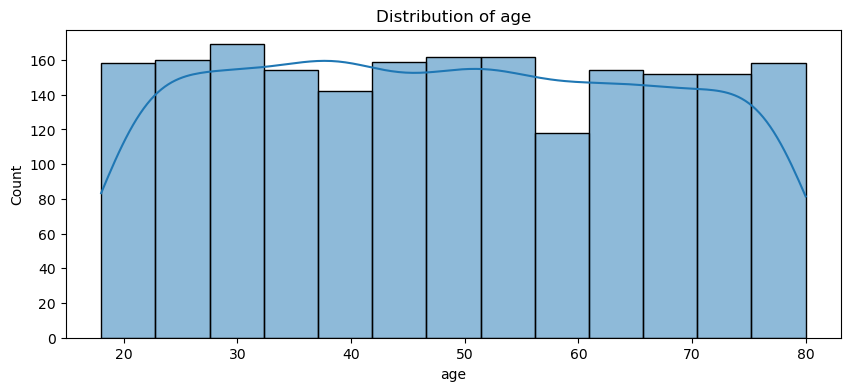

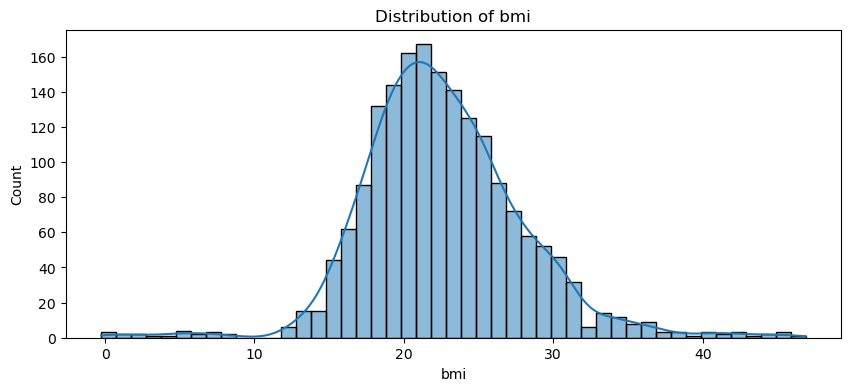

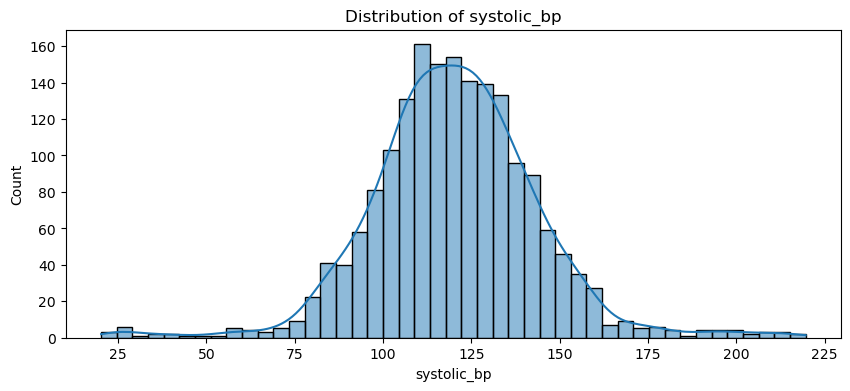

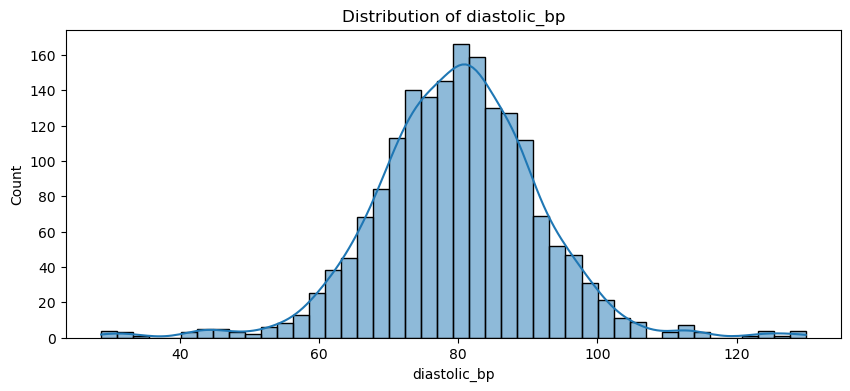

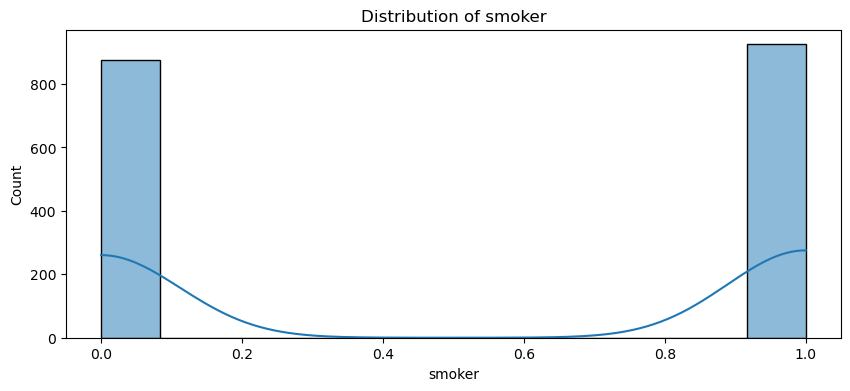

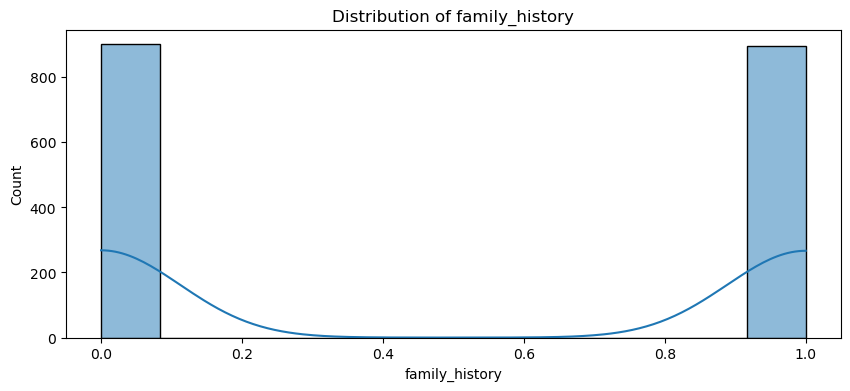

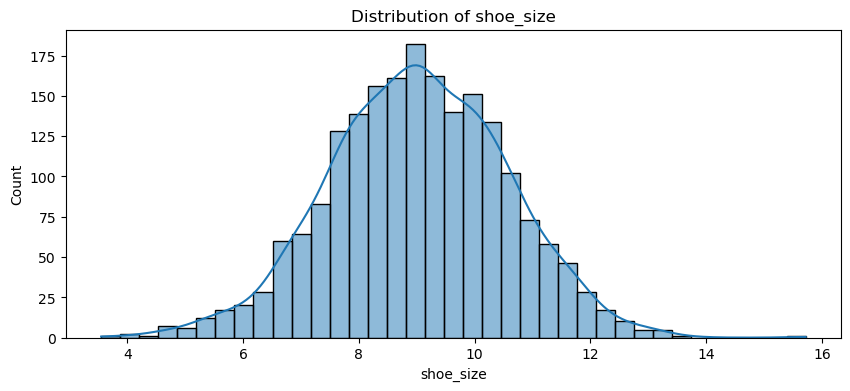

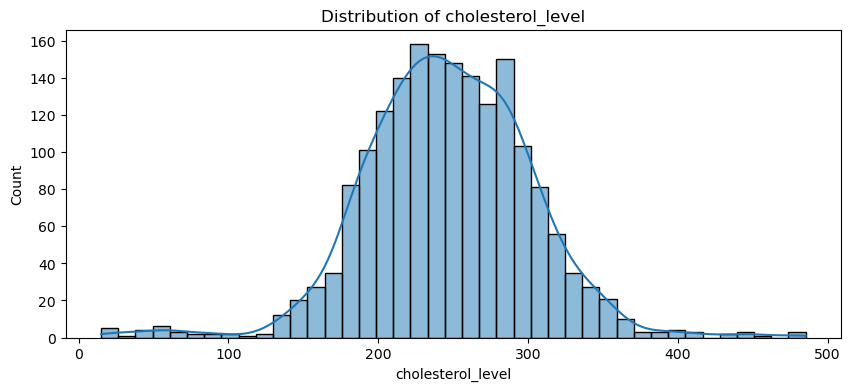

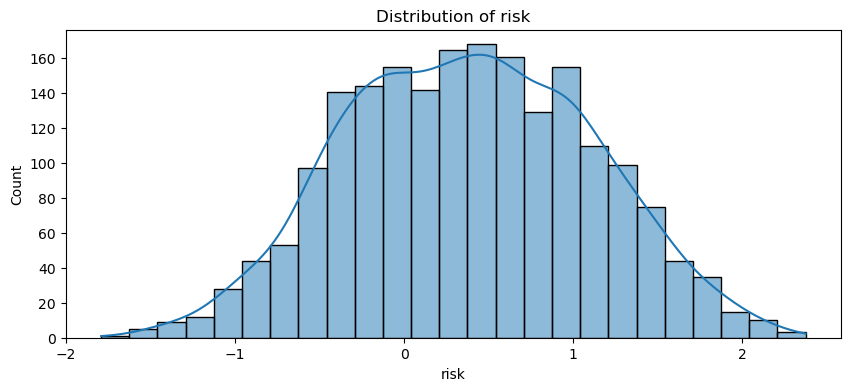

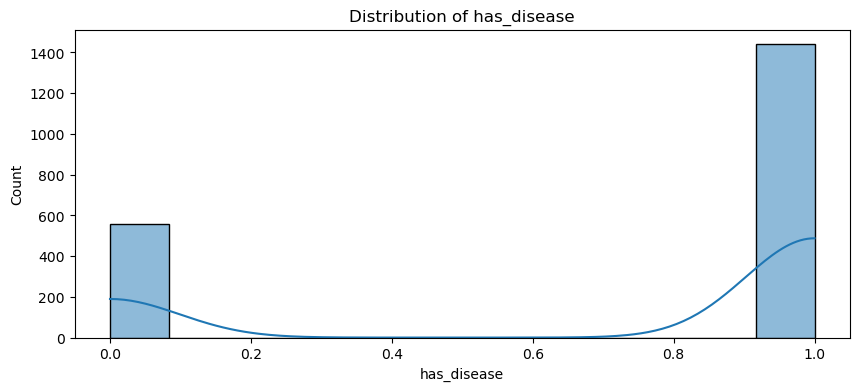

In [92]:
## Visualize distributions of numeric features
numeric_features = train_data.select_dtypes(include=[np.number]).columns
#hist_features = [['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'shoe_size','cholesterol_level','risk']]

for feature in numeric_features:
    plt.figure(figsize=(10, 4))
    sns.histplot(train_data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


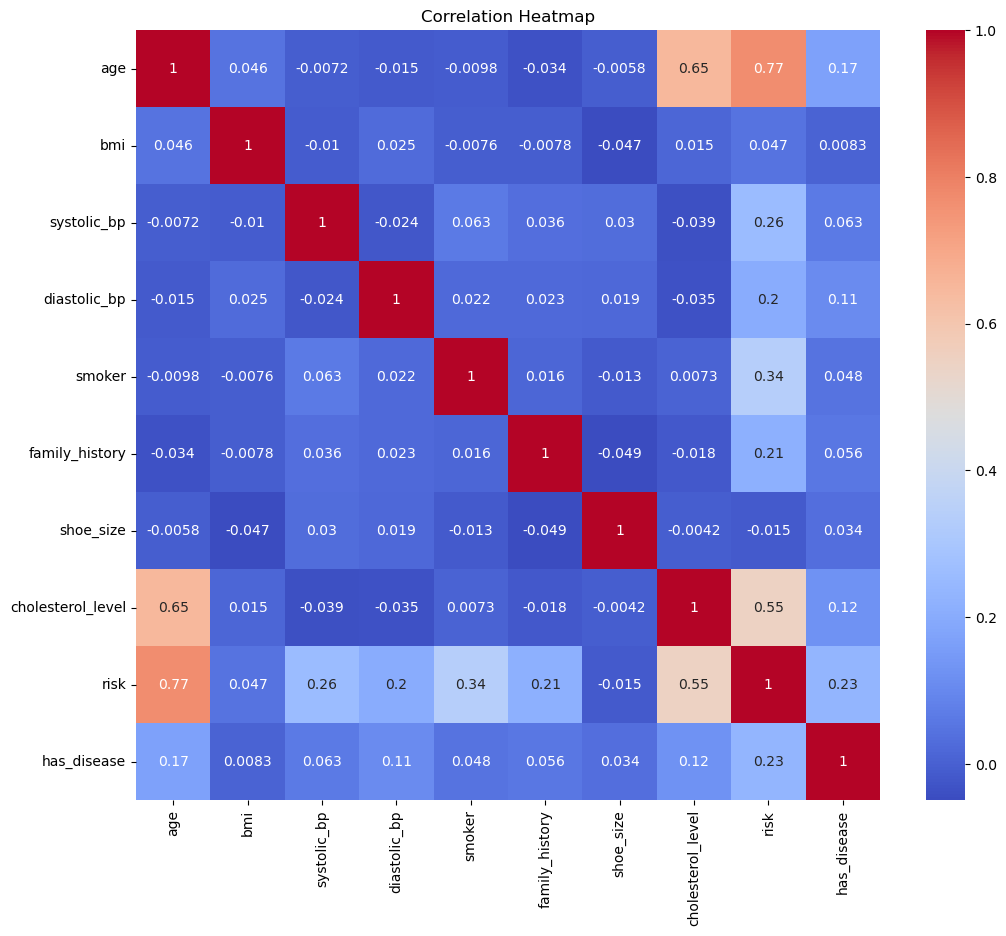


Value counts for gender:
gender
Male      1016
Female     984
Name: count, dtype: int64

Value counts for exercise_frequency:
exercise_frequency
Rarely          377
Regularly       365
Never           358
Frequently      358
Occasionally    347
Name: count, dtype: int64

Value counts for diet_quality:
diet_quality
Very Poor    394
Poor         376
Good         356
Average      336
Excellent    335
Name: count, dtype: int64

Value counts for us_state:
us_state
TX    220
CA    211
IL    205
OH    204
NY    204
FL    200
MI    194
GA    191
NC    187
PA    184
Name: count, dtype: int64


In [93]:
## Visualize correlations
correlation_matrix = train_data[numeric_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Examine categorical features
categorical_features = train_data.select_dtypes(include=['object']).columns
for feature in categorical_features:
    print(f"\nValue counts for {feature}:")
    print(train_data[feature].value_counts())


age                     Axes(0.125,0.712609;0.133621x0.167391)
bmi                  Axes(0.285345,0.712609;0.133621x0.167391)
systolic_bp           Axes(0.44569,0.712609;0.133621x0.167391)
diastolic_bp         Axes(0.606034,0.712609;0.133621x0.167391)
cholesterol_level    Axes(0.766379,0.712609;0.133621x0.167391)
dtype: object

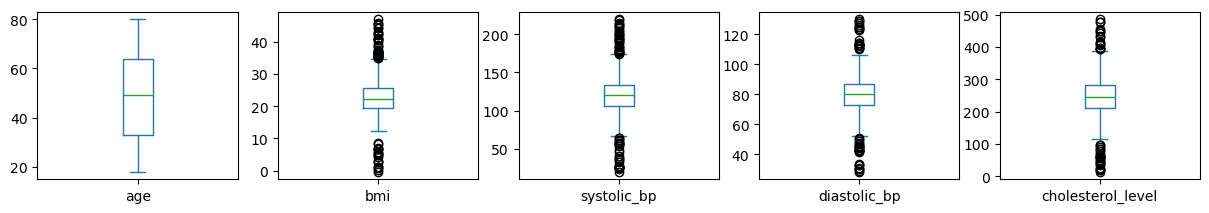

In [94]:
#check for outliers with box plot

numeric_columns = ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level']
numeric_data = train_data[numeric_columns]

numeric_data.plot.box(subplots=True, figsize=(15, 10), layout=(4, 5))

- From the Exploratory Data Analaysis, we see that most of the numerical variables are normally distributed with some outliers present in bmi, systolic_bp, distolic_bp and cholestrol_level

- We have missing data for following columns: bmi,systolic_bp,diastolic_bp,exercise_frequency,smoker,family_historydiet_quality, cholestrol_level

- Missing Data for binary variables can be imputed by using most frequent strategy 

- For categorical columns , i have used knnimputer and for numerical columns also knn imputer, I tried MICE too and it gave me the same final accuracy so kept knn imputer in the code


- We see that there is not a huge class imbalance between any input variable but there is class imbalance between the target variable which we will handle below using SMOTE

- I see high correaltion between risk and age ..even though it is less than 0.8, otherwise we could say there is Multicollinearity. Still i choose to remove the column from the model including shoe_size and the us_state since I dont think there is much relevance to that wrt to disease.




### Preprocessing

In [95]:

train_data = train_data.drop(columns=['us_state', 'shoe_size','risk'])

## Define column types
binary_columns = ['smoker', 'family_history']
gender_column = ['gender']
ordinal_columns = ['exercise_frequency', 'diet_quality']
numeric_columns = ['age', 'bmi', 'systolic_bp', 'diastolic_bp','cholesterol_level']


## Create preprocessing pipelines
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

gender_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
])

ordinal_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', KNNImputer(n_neighbors=5)),
])


#ordinal_pipeline = Pipeline([
 #   ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
  #  ('imputer', IterativeImputer(estimator=DecisionTreeRegressor(max_depth=5), 
   #                              max_iter=10, 
    #                             random_state=42)),
#])

#outlier removal using IQR 
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.low = None
        self.high = None

    def fit(self, X, y=None):
        Q1 = X[self.columns].quantile(0.25)
        Q3 = X[self.columns].quantile(0.75)
        IQR = Q3 - Q1
        self.low = Q1 - (self.factor * IQR)
        self.high = Q3 + (self.factor * IQR)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = np.clip(X_copy[col], self.low[col], self.high[col])
        return X_copy
    


numeric_pipeline = Pipeline([
    ('outlier_remover', OutlierRemover(columns=['age', 'bmi', 'systolic_bp', 'diastolic_bp', 'cholesterol_level'])),
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),  # MICE Imputer
    #('outlier_detector', IsolationForestOutlierDetector(contamination=0.15, random_state=42)),
    ('scaler', StandardScaler())
   # ('imputer', KNNImputer(n_neighbors=5)),
])

## Combine pipelines into a ColumnTransformer
preprocessor = ColumnTransformer([
    ('binary', binary_pipeline, binary_columns),
    ('gender', gender_pipeline, gender_column),
    ('ordinal', ordinal_pipeline, ordinal_columns),
    ('numeric', numeric_pipeline, numeric_columns),
])



- For Preprocessing, I had used MetaFeature using systolic_bp and diastolic_bp but the accuracy dropped so i removed it

- Separated Binary columns, numeric columns and categorical columns which required ordinal encoding and used on hot encoding for gender. At first I did ordinal encoding for gender but with one hot encoding , accuracy improved by 1%

- Created separate pipleine for each column type and used different Imputation methods and again changed between MICE AND KNN Imputer but there was no significant change in the accuracy.

- Created a OutlierRemover class. This class uses the IQR method to identify outliers.
- Added the class in the numerical pipeline to remove outliers


- Created a final column transformer to combine all preprocessing Pipeline.



#### Modelling and Evaluation

In [96]:

# Prepare the data
X = train_data.drop('has_disease', axis=1)
y = train_data['has_disease']


# Print class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts(normalize=True))



# List of classifiers
classifiers = [
   ('Logistic Regression', LogisticRegression(max_iter=1000)),
   ('SGD Classifier', SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)), 
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
   ('Gradient Boosting', GradientBoostingClassifier(random_state=42))

]

# Try different classifiers
for name, classifier in classifiers:
    clf_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier),
    ])
    cv_scores = cross_val_score(clf_pipeline, X, y, cv=5, scoring='f1')
    print(f"{name} - Mean F1 score: {cv_scores.mean()}")


Class distribution before SMOTE:
has_disease
1    0.72
0    0.28
Name: proportion, dtype: float64
Logistic Regression - Mean F1 score: 0.674071688002835
SGD Classifier - Mean F1 score: 0.5116583970569064
Random Forest - Mean F1 score: 0.7939372426443172
Gradient Boosting - Mean F1 score: 0.7818100345721415


- Separated the Input and output variable and then listed three different classifiers to test the model.

- Applied SMOTE because of the target variable class imbalance

- Created a Pipleine to use both preprocessor and then classifers 

- Tried 5 fold cross Validation to get the f1 score and achieved the Highest mean score of 79.3 by Random Forest

#### Test Data

In [97]:
# 4. Test data prediction

## Train the final model on the full training data
final_model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier()),  # Choose the best performing classifier
])
final_model.fit(X, y)

# Print class distribution after SMOTE ( this is just an approximation)
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(preprocessor.fit_transform(X), y)
print("\nApproximate class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True))


#applying the metfeature preprocessing to test_data
#test_data = preprocess_data(test_data)

## Make predictions on test data
test_predictions = final_model.predict(test_data)

## Save predictions to answers.csv
pd.DataFrame({'has_disease': test_predictions}).to_csv('answers.csv', index=False)

print("Predictions saved to answers.csv")


Approximate class distribution after SMOTE:
has_disease
1    0.5
0    0.5
Name: proportion, dtype: float64
Predictions saved to answers.csv


- Preapred a final model to make predictions on new data.
- First, it creates a complete pipeline that includes both the data preprocessing steps and the chosen classifier (Logistic Regression). It then trains this pipeline on all the available training data. After that, it applies the same preprocessing to the test data that it used on the training data. 
- Finally, it uses the trained model to make predictions on this preprocessed test data and saves these predictions to a file called 'answers.csv'.
- all the preprocessing steps learned from the training data are automatically applied to the test data. 
- This ensures that the test data is treated in exactly the same way as the training data, without any data leakage.